In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import re
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

from src.evaluation import evaluate_queries, calculate_f1, recall_at_k, precision_at_k
from src.vector_database import VectorDatabase, ClusterDatabase
from src.helpers import process_query_results, assign_levels

from pprint import pprint

import seaborn as sns
import matplotlib.pyplot as plt
import time


### Loading the sentence transformer

In [2]:
model = SentenceTransformer("all-MiniLM-L6-v2")

### Loading the documents/queries

In [3]:
base_path = Path("/Users/stighellemans/Desktop/Information_Retrieval/assignments/data")
base_small_doc_path = base_path / "full_docs_small"
base_large_doc_path = base_path / "full_docs"

small_docs = {int(re.search(r'\d+', doc_path.name).group()): doc_path for doc_path in base_small_doc_path.glob("*.txt")}
large_docs = {int(re.search(r'\d+', doc_path.name).group()): doc_path for doc_path in base_large_doc_path.glob("*.txt")}

small_queries = pd.read_csv(base_path / "dev_small_queries - dev_small_queries.csv", index_col="Query number").to_dict()["Query"]
small_query_results = pd.read_csv(base_path / "dev_query_results_small.csv", index_col="Query_number")
small_query_results = process_query_results(small_query_results)

large_queries = pd.read_csv(base_path / "dev_queries.tsv", delimiter="\t", index_col="Query number").head(1000).to_dict()["Query"]
large_query_results = pd.read_csv(base_path / "dev_query_results.csv", index_col="Query_number")
large_query_results = process_query_results(large_query_results)

# test_queries = pd.read_csv(base_path / "queries.csv", delimiter="\t", index_col="Query number").to_dict()["Query"]


### Training the vector database

In [ ]:
db = VectorDatabase(model)
db.encode_docs(large_docs)
db.save_database("results/large_db")

In [ ]:
small_db = VectorDatabase(model)
small_db.encode_docs(small_docs)
small_db.save_database("results/small_db")

100%|██████████| 1557/1557 [00:16<00:00, 93.65it/s] 


### Loading the vector database

In [4]:
db = VectorDatabase(model)
db.load_database("results/large_db")

# cluster_db = ClusterDatabase(model, n_clusters=100)
# cluster_db.load_database("results/large_db")

In [4]:
small_db = VectorDatabase(model)
small_db.load_database("results/small_db")

small_cluster_db = ClusterDatabase(model, n_clusters=10)
small_cluster_db.load_database("results/small_db")

### Visualization of clusters

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


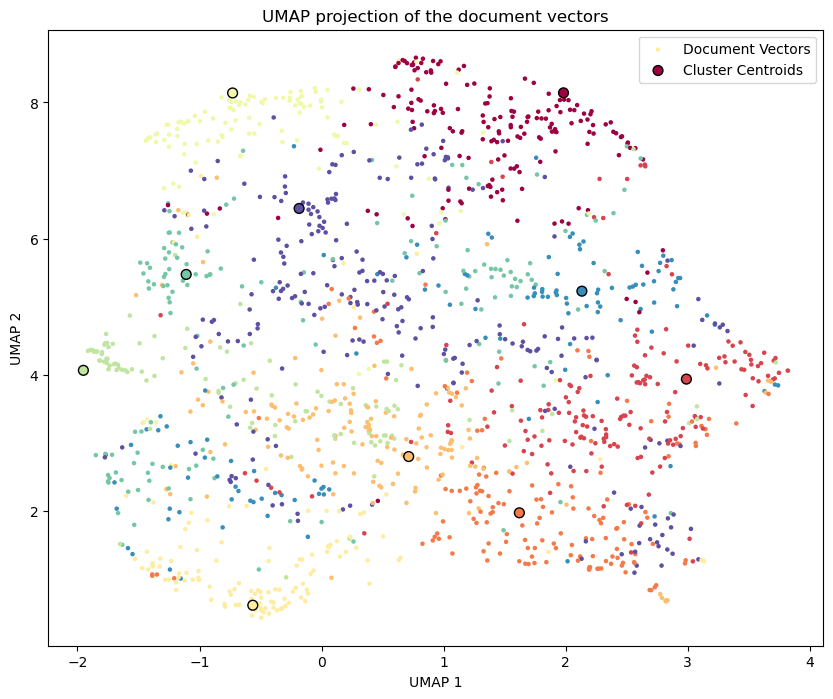

In [32]:
import umap

# Perform UMAP dimensionality reduction
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(small_cluster_db.doc_vectors)

cluster_embedding = reducer.transform(small_cluster_db.kmeans.cluster_centers_)

include = (embedding < 10).all(axis=1)
embedding = embedding[include]

# Plot the 2D UMAP
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], s=5, c=small_cluster_db.kmeans.labels_[include], cmap='Spectral', label='Document Vectors')
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=50, c=np.arange(cluster_embedding.shape[0]), cmap='Spectral', edgecolor='black', label='Cluster Centroids')
plt.title('UMAP projection of the document vectors')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.show()

### Euclidean distance vs cosine similarity

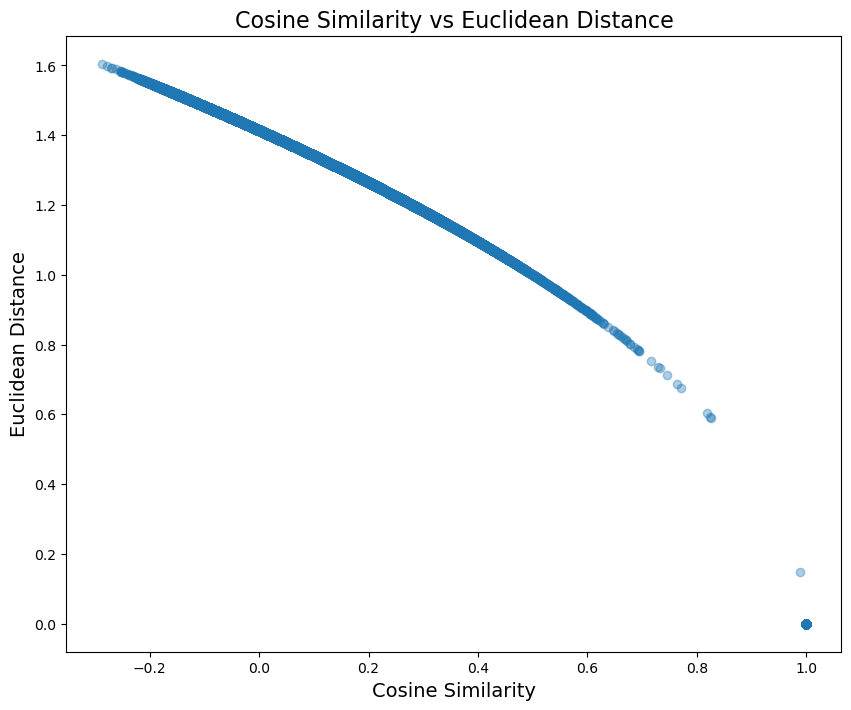

In [40]:
from scipy.spatial.distance import pdist, squareform

cosine_similarity = np.dot(small_db.doc_vectors, small_db.doc_vectors.T).flatten()
# Calculate the Euclidean distance between all vectors
euclidean_distances = squareform(pdist(small_db.doc_vectors, metric='euclidean'))
euclidean_distances = euclidean_distances.flatten()

# Plot the cosine similarity and euclidean distance
plt.figure(figsize=(10, 8))
plt.scatter(cosine_similarity, euclidean_distances, alpha=0.2)
plt.title('Cosine Similarity vs Euclidean Distance', fontsize=16)
plt.xlabel('Cosine Similarity', fontsize=14)
plt.ylabel('Euclidean Distance', fontsize=14)
plt.show()

### Evaluation

In [11]:
evaluate_queries(large_queries, large_query_results, k_values=[1, 3, 5, 10], database=db)

Searching document batches: 100%|██████████| 101/101 [00:09<00:00, 10.79it/s]

Aggregating final


{1: {'Precision': 0.492, 'Recall': 0.03281815049276214},
 3: {'Precision': 0.368, 'Recall': 0.07281256834250237},
 5: {'Precision': 0.30800000000000005, 'Recall': 0.10104884092906638},
 10: {'Precision': 0.2295, 'Recall': 0.14954967288204532}}

In [9]:
evaluate_queries(small_queries, small_query_results, k_values=[1, 3, 5, 10], database=small_db)

Searching document batches: 100%|██████████| 1/1 [00:00<00:00, 101.01it/s]

Aggregating final


{1: {'Precision': 0.5040322580645161, 'Recall': 0.49798387096774194},
 3: {'Precision': 0.2217741935483871, 'Recall': 0.6532258064516129},
 5: {'Precision': 0.1435483870967742, 'Recall': 0.7036290322580645},
 10: {'Precision': 0.07782258064516127, 'Recall': 0.7620967741935484}}

### Cluster hyperparameters

In [17]:
n_clusters = [2, 5, 10, 50, 100, 200]

k = 10
max_partitions = 10

results = []

metrics =  evaluate_queries(large_queries, large_query_results, k_values=[k], database=db)[k]
results.append({"database": "Vector Database", "clusters": 0, 
                "top_c": 0, f"MAP@{k}": metrics["Precision"], 
                f"MAR@{k}": metrics["Recall"], 
                f"MAF1@{k}": calculate_f1(metrics["Precision"], metrics["Recall"]),
                "cluster_time": 0, "query_time": 0
                })

n = 0
for n_cluster in n_clusters:
    print(n_cluster)

    start_time = time.time()
    large_cluster_db = ClusterDatabase(model, n_clusters=n_cluster)
    large_cluster_db.load_database("results/large_db")
    cluster_time = time.time() - start_time
    print(f"Time taken for creating {n_cluster} clusters: {cluster_time} seconds") 
    top_c_values = np.unique(np.linspace(1, n_cluster, num=max_partitions, dtype=int))

    for top_c in tqdm(top_c_values, total=len(top_c_values)):
        start_time = time.time()
        metrics = evaluate_queries(large_queries, large_query_results, k_values=[k], 
                                   database=large_cluster_db, top_c=top_c, verbose=False
                                   )[k]
        query_time = time.time() - start_time
        results.append({"database": "Cluster Database", "clusters": n_cluster, 
                        "top_c": top_c, f"MAP@{k}": metrics["Precision"], 
                        f"MAR@{k}": metrics["Recall"], 
                        f"MAF1@{k}": calculate_f1(metrics["Precision"], metrics["Recall"]),
                        "cluster_time": cluster_time, "query_time": query_time
                        })



results = pd.DataFrame(results)
results.to_csv("results/cluster_results.csv", index=False)

Searching document batches: 100%|██████████| 101/101 [00:10<00:00,  9.59it/s]


2


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Time taken for creating 2 clusters: 5.679127216339111 seconds


100%|██████████| 2/2 [00:18<00:00,  9.34s/it]


5
Time taken for creating 5 clusters: 12.56412410736084 seconds


100%|██████████| 5/5 [00:40<00:00,  8.02s/it]


10
Time taken for creating 10 clusters: 8.147532939910889 seconds


100%|██████████| 10/10 [01:39<00:00,  9.97s/it]


50
Time taken for creating 50 clusters: 29.911212921142578 seconds


100%|██████████| 10/10 [03:24<00:00, 20.47s/it]


100
Time taken for creating 100 clusters: 63.11960291862488 seconds


100%|██████████| 10/10 [04:28<00:00, 26.89s/it]


200
Time taken for creating 200 clusters: 171.91016507148743 seconds


100%|██████████| 10/10 [04:58<00:00, 29.81s/it]


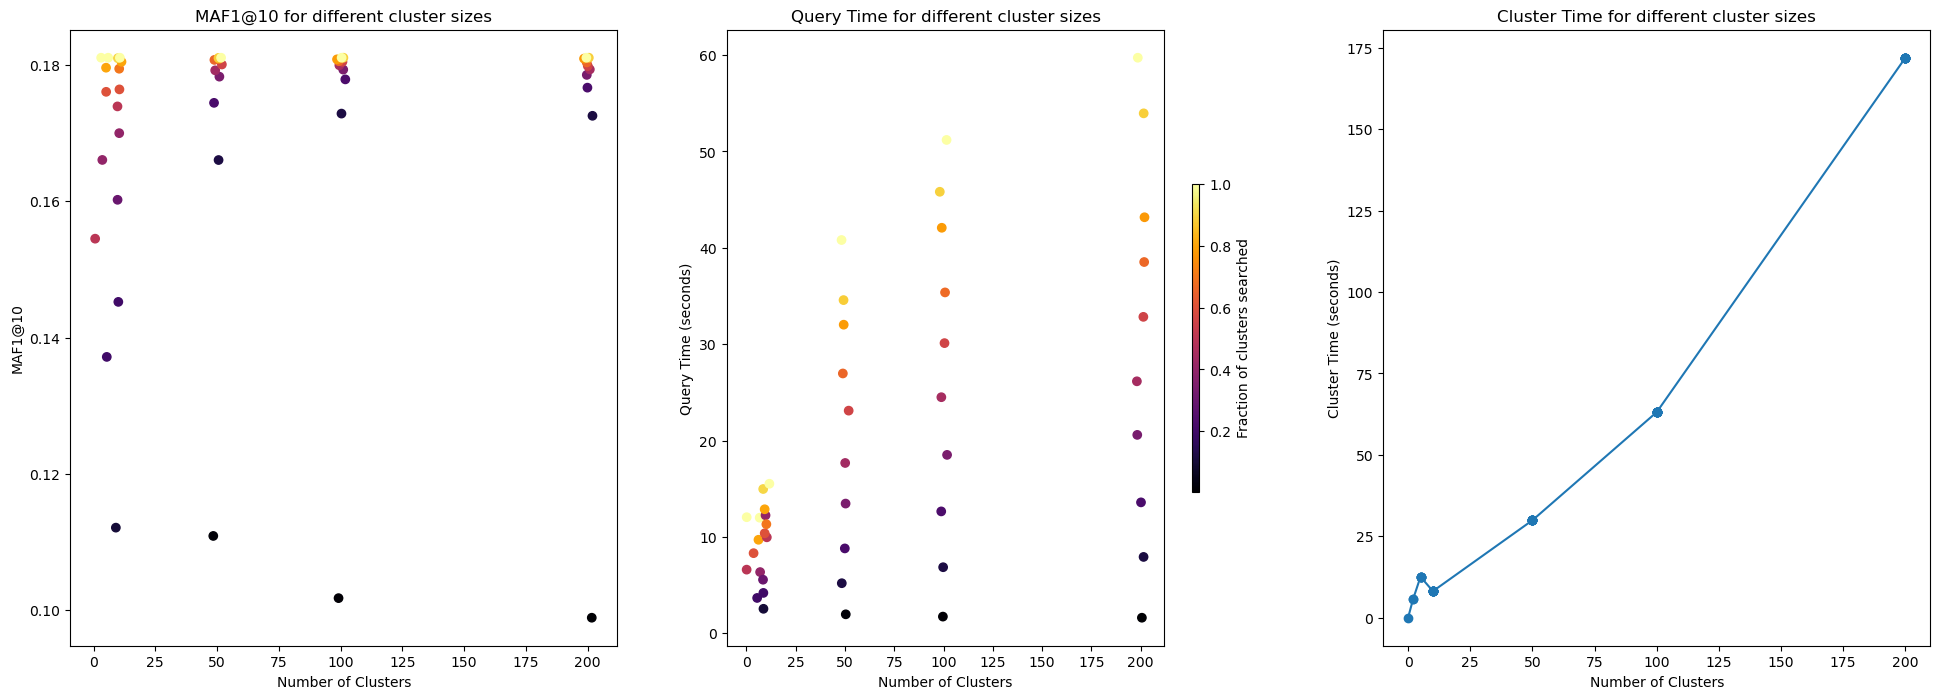

<Figure size 640x480 with 0 Axes>

In [19]:
import matplotlib.colors as mcolors

k = 10

results = pd.read_csv("results/cluster_results.csv")

# Extract data and add jitter dynamically for MAF1@k
x1 = results["clusters"] + np.random.uniform(-2, 2, len(results))
y1 = results[f"MAF1@{k}"]
hue1 = results["top_c"] / results["clusters"]

# Normalize the hue values for the colormap
norm1 = mcolors.Normalize(vmin=hue1.min(), vmax=hue1.max())
cmap1 = plt.cm.inferno

# Extract data and add jitter dynamically for query_time
x2 = results["clusters"] + np.random.uniform(-2, 2, len(results))
y2 = results["query_time"]
hue2 = results["top_c"] / results["clusters"]

# Normalize the hue values for the colormap
norm2 = mcolors.Normalize(vmin=hue2.min(), vmax=hue2.max())
cmap2 = plt.cm.inferno

# Create the figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8), sharey=False)

# Create the first plot for MAF1@k
scatter1 = ax1.scatter(x1, y1, c=hue1, cmap=cmap1, norm=norm1)
ax1.set_title(f"MAF1@{k} for different cluster sizes")
ax1.set_xlabel("Number of Clusters")
ax1.set_ylabel(f"MAF1@{k}")

# Create the second plot for query_time
scatter2 = ax2.scatter(x2, y2, c=hue2, cmap=cmap2, norm=norm2)
ax2.set_title("Query Time for different cluster sizes")
ax2.set_xlabel("Number of Clusters")
ax2.set_ylabel("Query Time (seconds)")

# Add colorbar for the second plot
cbar2 = plt.colorbar(scatter2, ax=ax2, label="Fraction of clusters searched", orientation="vertical", aspect=40, shrink=0.5)

# Plot the line plot for cluster_time
ax3.plot(results["clusters"], results["cluster_time"], marker='o', linestyle='-')

ax3.set_title("Cluster Time for different cluster sizes")
ax3.set_xlabel("Number of Clusters")
ax3.set_ylabel("Cluster Time (seconds)")

# Show the figure
plt.show()


# Show the combined figure
plt.tight_layout()
plt.show()


### Hierarchical Navigable Small World (HNSW)

In [ ]:
def highest_level(highest_levels):
    """
    Returns the highest level of the document.

    Parameters:
    highest_levels (np.ndarray): Array of highest levels for each document.

    Returns:
    int: The highest level of the document.
    """
    return np.max(highest_levels)

def layer(level, highest_levels):
    """
    Returns the indices of documents that are at or above the specified level.

    Parameters:
    level (int): The level to filter documents by.
    highest_levels (np.ndarray): Array of highest levels for each document.

    Returns:
    np.ndarray: Indices of documents at or above the specified level.
    """
    if level == -1:
        level = highest_level(highest_levels)
    return np.where(highest_levels >= level)[0]

def make_edges(current_layer, doc_vectors, n_neighbors):
    """
    Creates edges between documents based on cosine similarity.

    Parameters:
    current_layer (np.ndarray): Indices of documents in the current layer.
    doc_vectors (np.ndarray): Document vectors.
    n_neighbors (int): Number of neighbors to connect to each document.

    Returns:
    np.ndarray: Array of edges for the current layer.
    """
    k = n_neighbors + 1
    edges = []
    for i in tqdm(current_layer):
        sims = np.dot(doc_vectors[current_layer], doc_vectors[i])
        if sims.shape[0] > k:
            closest_indices = np.argpartition(-sims, k, axis=0)[1:k]
        else:
            closest_indices = np.argsort(-sims, axis=0)[1:k]
        
        edges.append(closest_indices)
    edges = np.array(edges)
    return edges


doc_vectors = db.doc_vectors
n_neighbors = 5
highest_levels = assign_levels(n_neighbors, len(doc_vectors))

translate = np.vectorize(db.translate_id)

# Initialize an empty list to store edges for each level
edges = []
indexes = []

# Loop through each level from 0 to the maximum level
for level in range(highest_level(highest_levels) + 1):
    # Get the indices of documents that are at or above the current level
    current_layer = layer(level, highest_levels)
    print("level", level, "num_vectors", len(current_layer))

    # Create edges for the current layer based on cosine similarity
    layer_edges = make_edges(current_layer, doc_vectors, n_neighbors)
    print(layer_edges.shape)
    
    # Append the edges of the current layer to the edges list
    edges.append(layer_edges)

level 0 num_vectors 1557


100%|██████████| 1557/1557 [00:00<00:00, 2422.21it/s]


(1557, 5)
level 1 num_vectors 299


100%|██████████| 299/299 [00:00<00:00, 13426.16it/s]


(299, 5)
level 2 num_vectors 64


100%|██████████| 64/64 [00:00<00:00, 37532.92it/s]


(64, 5)
level 3 num_vectors 11


100%|██████████| 11/11 [00:00<00:00, 31709.51it/s]


(11, 5)
level 4 num_vectors 3


100%|██████████| 3/3 [00:00<00:00, 31223.11it/s]

(3, 2)


In [225]:
seek = 0
current = 5
while current != seek:
    # print(indexes[current, -1])
    print(edges[-2][current])
    current = np.random.choice(edges[-2][current])
    print(current)

# for edge in edges:
#     print(edge.shape)

# print(max(highest_levels))
# for level in range(highest_level(highest_levels) + 1):
#     print(highest_level(highest_levels))
#     print(layer(level, highest_levels).shape)
#     print(layer(-1, highest_levels))

edges[-2]


[10  9  4  8  1]
8
[ 5  2  9  8 10]
2
[0 2 9 8 5]
9
[0 2 9 8 5]
9
[0 2 9 8 5]
0


array([[ 0,  1, 10,  2,  9],
       [10,  1,  0,  6,  3],
       [ 0,  2,  9,  8,  5],
       [ 3,  6,  0,  4,  7],
       [10,  7,  3,  4,  5],
       [10,  9,  4,  8,  1],
       [ 0,  2,  3,  7,  1],
       [ 7,  9,  3,  6,  5],
       [ 5,  2,  9,  8, 10],
       [ 0,  2,  9,  8,  5],
       [10,  0,  5,  4,  9]])

In [354]:
def get_neighbours(edge_idxs, layer_edges):
    return layer_edges[edge_idxs]

def get_vector_idxs(edge_idxs, current_layer):
    return np.vectorize(lambda idx: current_layer[idx])(edge_idxs)

def traverse_layer(probe, level_edges, doc_vectors):
    not_best = True
    while not_best:
        neighbours = get_neighbours(start, level_edges)

def get_edge_idxs(vector_indxs, current_layer):
    return np.vectorize(lambda idx: np.where(current_layer == idx)[0][0])(vector_indxs)


query_vectors = doc_vectors[np.argpartition(highest_levels, 10)][:2]

# probes = np.repeat(layer(-1, highest_levels), query_vectors.shape[0], axis=0)
# print(probes)
probes = np.repeat(layer(-1, highest_levels)[: , np.newaxis], query_vectors.shape[0], axis=1)
done = np.zeros_like(probes, dtype=np.bool_)
current_level = highest_level(highest_levels) - 1
current_layer = layer(current_level, highest_levels)
probe_edge_idxs = get_edge_idxs(probes, current_layer)

print(probes)

while not np.all(done):
    neighbours = get_neighbours(probe_edge_idxs, edges[current_level])
    nn_vector_idxs = get_vector_idxs(neighbours, current_layer)

    probe_sims = np.einsum('pkd,kd->pk', doc_vectors[probes], query_vectors)
    nn_sims = np.einsum('pknd,kd->pkn', doc_vectors[nn_vector_idxs], query_vectors)

    # Get the best neigbours
    best_idxs = np.argmax(nn_sims, axis=-1)
    best_nn_idxs = np.take_along_axis(neighbours, best_idxs[..., np.newaxis], axis=-1).squeeze()
    best_sims = np.take_along_axis(nn_sims, best_idxs[..., np.newaxis], axis=-1).squeeze()
    print("probe", probe_edge_idxs)
    print("nns", best_nn_idxs)

    

    done = (best_sims <= probe_sims)
    final_probes = probe_edge_idxs[done].flatten()
    duplicate = np.where(np.isin(best_nn_idxs, final_probes))
    probe_edge_idxs = np.where(done | duplicate, probe_edge_idxs, best_nn_idxs)
    probes = get_vector_idxs(probe_edge_idxs, current_layer)
    print(done)
    print(probes)


sims = np.dot(doc_vectors[current_layer], query_vectors.T)
# print(sims.shape)

idxs = np.argpartition(-sims, 3, axis=0)[:3]
vector_idxs = get_vector_idxs(idxs, current_layer)

vector_idxs, np.take_along_axis(sims, idxs, axis=0).squeeze()

    # current_layer = [start]
    # for level in range(max(highest_levels) - 1):
    #     print("level", level, "num_vectors", len(current_layer))
    #     layer_edges = make_edges(current_layer, doc_vectors, n_neighbors)
    #     print(layer_edges.shape)
    #     edges.append(layer_edges)
    #     current_layer = np.unique(layer_edges.flatten())

[[ 839  839]
 [1004 1004]
 [1555 1555]]
probe [[ 5  5]
 [ 6  6]
 [10 10]]
nns [[1 8]
 [1 7]
 [9 9]]


ValueError: operands could not be broadcast together with shapes (3,2) (2,0) 

In [56]:
from typing import Dict, Sequence, Union
from src.helpers import search, aggregate


DocID = Union[int, str]

class HnswDatabase(VectorDatabase):
    def __init__(self, encoder: SentenceTransformer, n_neighbors: int = 5):
        self.doc_ids = {}
        self.doc_vectors = np.array([])
        self.encoder = encoder
        self.n_neighbors = n_neighbors
        self.highest_levels = np.array([])

    def encode_docs(self, doc_paths: Dict[DocID, Path], batch_size=500):
        self.doc_vectors = []
        self.doc_ids = {}

        doc_texts = []
        doc_vectors = []
        for i, (doc_id, doc_path) in tqdm(
            enumerate(doc_paths.items()), total=len(doc_paths)
        ):
            with open(doc_path) as file:
                doc_text = file.read()
                doc_texts.append(doc_text)
                self.doc_ids[i] = doc_id
            if i % batch_size == 0 and i != 0:
                doc_vectors.append(np.array(self.encoder.encode(doc_texts)))
                doc_texts = []

        doc_vectors = np.concatenate(doc_vectors)
        self.train()
    
    def _layer(self, level):
        if level == -1:
            level = max(self.highest_levels)
        return np.where(self.highest_levels >= level)[0]

    def search_queries(self, queries: Sequence[str], k: int, top_c: int) -> np.ndarray:
        query_vectors = self.encode_text(queries)
        top_c = min(top_c, self.n_clusters)

        # Compute similarity of cluster centers to queries
        sims = np.dot(self.kmeans.cluster_centers_, query_vectors.T)
        query_top_k_clusters = np.argsort(-sims, axis=0)[:top_c]

        retrieved_doc_ids = np.empty((top_c * k, len(queries)))
        retrieved_sims = np.empty((top_c * k, len(queries)))

        for c, cluster_doc_ids in tqdm(
            enumerate(self.doc_ids_split),
            total=self.n_clusters,
            desc="Searching clusters",
        ):
            cluster_doc_vectors = self.doc_vectors[cluster_doc_ids]
            for i in range(top_c):
                queries_per_cluster = np.where(query_top_k_clusters[i, :] == c)[0]

                if queries_per_cluster.size == 0:
                    continue

                top_k_cluster_indices, top_k_sims = search(
                    cluster_doc_vectors,
                    query_vectors[queries_per_cluster],
                    k,
                    load_bar=False,
                )
                top_k_indices = cluster_doc_ids[top_k_cluster_indices]

                retrieved_doc_ids[i * k : (i + 1) * k, queries_per_cluster] = (
                    top_k_indices
                )
                retrieved_sims[i * k : (i + 1) * k, queries_per_cluster] = top_k_sims

        retrieved_doc_ids, _ = aggregate(retrieved_doc_ids, retrieved_sims, k)
        vectorized_translate = np.vectorize(self.translate_id)
        return vectorized_translate(retrieved_doc_ids)

    def train(self):
        pass

    def load_vectors(self, path: Union[str, Path]):
        self.doc_vectors = np.load(path)
        self.train()

    def load_ids(self, path: Union[str, Path]):
        self.doc_ids = pd.read_csv(path).set_index("index").to_dict()["doc_id"]
    



ImportError: cannot import name 'search' from 'src.helpers' (/Users/stighellemans/Desktop/Information_Retrieval/assignments/assignment 3/semantic_search_and_retrieval_with_sbert/src/helpers.py)